# Data Loading

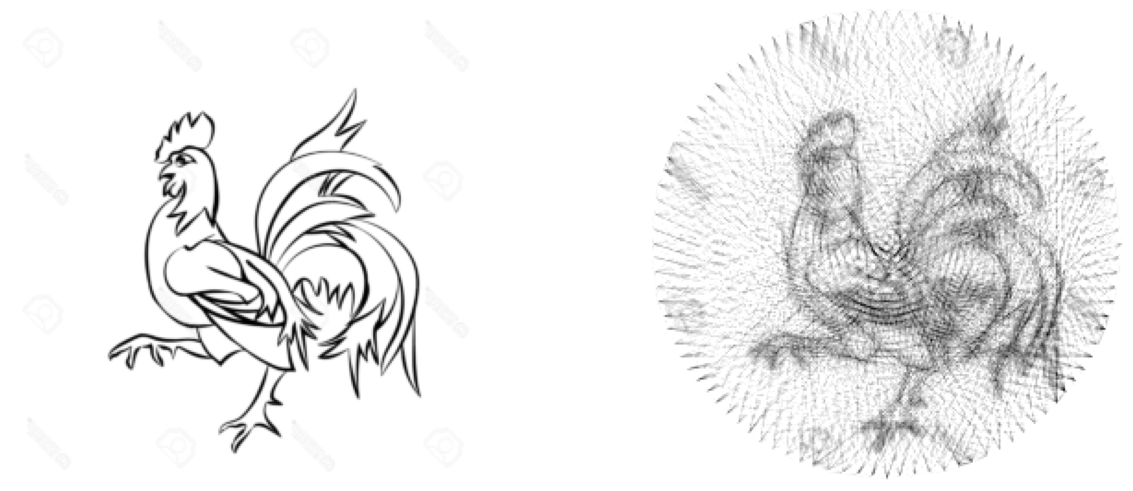

In [1]:
import os

import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from skimage.io import imread
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.functional import to_tensor
from typing import Tuple


class Config:
    DATASET_DIR = "/kaggle/input/stringart-ai-1000/stringart-dataset"
    UNET_PLOT_DIR= "/kaggle/working"
    

class StringArtDataset(Dataset):
    def __init__(self, file_list):
        self.file_list = file_list

        self.images = []
        self.labels = []

        for img_path, label_path in self.file_list:
            img = np.array(imread(img_path))
            label = np.array(imread(label_path))

            self.images.append(to_tensor(img))
            self.labels.append(to_tensor(label))

        self.images = torch.stack(self.images)
        self.labels = torch.stack(self.labels)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


def load_data(input_dir: str, batch_size: int = 64) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """Load the dataset from the specified directory, split it into training, validation, and test sets,
    and return corresponding DataLoaders for each set.

    Parameters
    ----------
    input_dir : str
        The directory path containing the dataset. It should have a `metadata.csv` file and
        subdirectories `images` and `labels` containing the image and label files, respectively.
    batch_size : int, optional
        The batch size for the DataLoader. Default is 64.

    Returns
    -------
    tuple
        A tuple containing three `DataLoader` objects:
        - train_loader (DataLoader): The DataLoader for the training dataset.
        - validation_loader (DataLoader): The DataLoader for the validation dataset.
        - test_loader (DataLoader): The DataLoader for the test dataset.
    """

    df = pd.read_csv(os.path.join(input_dir, "metadata.csv"))
    samples = [
        (os.path.join(input_dir, "images", img_name), os.path.join(input_dir, "labels", label_name))
        for _, (img_name, label_name) in df.iterrows()
    ]

    train_data, temp_data = train_test_split(samples, test_size=0.3, random_state=42)
    validation_data, test_data = train_test_split(temp_data, test_size=0.1, random_state=42)

    train_loader = DataLoader(StringArtDataset(train_data), batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(StringArtDataset(validation_data), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(StringArtDataset(test_data), batch_size=batch_size, shuffle=False)

    return train_loader, validation_loader, test_loader



train_loader, validation_loader, test_loader = load_data(Config.DATASET_DIR, batch_size=16)

batch = next(iter(train_loader))
img, label = batch[0][0], batch[1][0]

image = img.cpu().numpy().transpose(1, 2, 0)
label = label.cpu().numpy().transpose(1, 2, 0)

fig, axs = plt.subplots(1, 2, figsize=[2 * 6.4, 4.8], constrained_layout=True)
cmap = "gray"

axs[0].imshow(image, cmap=cmap)
axs[0].set_axis_off()

axs[1].imshow(label, cmap=cmap)
axs[1].set_axis_off()

fig.show()


In [2]:
import torch
from torch import nn, optim

class DoubleConv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv2d, self).__init__()

        self.double_conv2d = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.double_conv2d(x)


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        self.encoder = nn.ModuleList(
            [
                DoubleConv2d(in_channels, 16),
                DoubleConv2d(16, 32),
                DoubleConv2d(32, 64),
                DoubleConv2d(64, 128),
                DoubleConv2d(128, 256),
            ]
        )

        self.decoder = nn.ModuleList(
            [
                DoubleConv2d(256, 128),
                DoubleConv2d(128, 64),
                DoubleConv2d(64, 32),
                DoubleConv2d(32, 16),
            ]
        )

        self.deconv = nn.ModuleList(
            [
                nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
                nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
                nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
                nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            ]
        )

        self.pool = nn.MaxPool2d((2, 2))
        self.last_layer_conv = nn.Conv2d(in_channels=16, out_channels=out_channels, kernel_size=1, stride=1)

    def forward(self, x):
        stk = []
        for encoder in self.encoder:
            x = encoder(x)
            stk.append(x)
            x = self.pool(x)

        x = stk.pop(-1)
        for index in range(len(self.decoder)):
            encoder_output = stk.pop(-1)
            x = self.deconv[index](x)

            x = torch.cat([encoder_output, x], dim=1)
            x = self.decoder[index](x)

        return torch.sigmoid(self.last_layer_conv(x))

In [3]:
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=2):
        # 2 in_channels, one for real and one for generated
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2, 1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 1, 4, 1, 1),
            nn.Sigmoid(),
        )

    def forward(self, x, y):
        # x: input image, y: real or generated output image
        return self.model(torch.cat([x, y], dim=1))

# Training Functions

In [11]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import os


def train_gan(
    generator: torch.nn.Module,
    discriminator: torch.nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion_gan: torch.nn.Module,
    criterion: torch.nn.Module,
    optimizer_generator: torch.optim.Optimizer,
    optimizer_discriminator: torch.optim.Optimizer,
    epochs: int,
    lambda_loss: int = 10,
    accumulation_steps: int = 4,
    device: torch.device = None,
):
    """Train a GAN model with optional gradient accumulation.

    Parameters
    ----------
    generator : torch.nn.Module
        The generator model.
    discriminator : torch.nn.Module
        The discriminator model.
    train_loader : DataLoader
        DataLoader for the training dataset.
    val_loader : DataLoader
        DataLoader for the validation dataset.
    criterion_gan : torch.nn.Module
        Loss function for GAN (e.g., BCEWithLogitsLoss).
    criterion : torch.nn.Module
        Loss function for pixel-wise loss (e.g., L1Loss, SSIM).
    optimizer_generator : torch.optim.Optimizer
        Optimizer for the generator.
    optimizer_discriminator : torch.optim.Optimizer
        Optimizer for the discriminator.
    epochs : int
        Number of training epochs.
    lambda_loss : int, optional
        Weight for criterion loss (default is 100).
    accumulation_steps : int, optional
        Number of steps to accumulate gradients before optimizer step (default is 4).
    device : torch.device, optional
        Device to run the training on (default is CUDA if available).

    Returns
    -------
    train_loss_history : list of float
        List of average training losses per epoch.
    val_loss_history : list of float
        List of average validation losses per epoch.
    """

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    generator.to(device)
    discriminator.to(device)

    train_loss_history = []
    val_loss_history = []

    running_train_loss = 0.0
    running_train_gan_loss = 0.0
    running_train_l1_loss = 0.0

    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")
        print("-" * 30)

        generator.train()
        discriminator.train()

        # training phase
        for index, (inputs, labels) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
            inputs, labels = inputs.to(device), labels.to(device)

            # train discriminator
            optimizer_discriminator.zero_grad()
            fake_images = generator(inputs)

            discriminator_real = discriminator(inputs, labels)
            discriminator_fake = discriminator(inputs, fake_images.detach())

            real_labels = torch.full_like(discriminator_real, 0.9, device=device)
            fake_labels = torch.zeros_like(discriminator_fake, device=device)

            loss_discriminator_real = criterion_gan(discriminator_real, real_labels)
            loss_discriminator_fake = criterion_gan(discriminator_fake, fake_labels)
            loss_discriminator = (loss_discriminator_real + loss_discriminator_fake) * 0.5

            loss_discriminator = loss_discriminator / accumulation_steps
            loss_discriminator.backward()

            if (index + 1) % accumulation_steps == 0:
                optimizer_discriminator.step()

            # train generator
            optimizer_generator.zero_grad()
            
            discriminator_for_generator = discriminator(inputs, fake_images)
            loss_generator_GAN = criterion_gan(discriminator_for_generator, real_labels)
            loss_generator_L1 = criterion(fake_images, labels) * lambda_loss
            loss_generator = loss_generator_GAN + loss_generator_L1

            loss_generator = loss_generator / accumulation_steps
            loss_generator.backward()

            if (index + 1) % accumulation_steps == 0:
                optimizer_generator.step()

            running_train_loss += loss_generator.item()
            running_train_gan_loss += loss_generator_GAN.item()
            running_train_l1_loss += loss_generator_L1.item()

        avg_train_loss = running_train_loss / len(train_loader)
        avg_train_gan_loss = running_train_gan_loss / len(train_loader)
        avg_train_l1_loss = running_train_l1_loss / len(train_loader)
        
        train_loss_history.append(avg_train_loss)

        running_train_loss = 0.0
        running_train_gan_loss = 0.0
        running_train_l1_loss = 0.0

        # validation phase
        generator.eval()
        discriminator.eval()
        running_val_loss = 0.0
        running_val_gan_loss = 0.0
        running_val_l1_loss = 0.0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation", leave=False):
                inputs, labels = inputs.to(device), labels.to(device)

                fake_images = generator(inputs)
                discriminator_for_generator = discriminator(inputs, fake_images)

                loss_generator_GAN = criterion_gan(
                    discriminator_for_generator, torch.ones_like(discriminator_for_generator, device=device)
                )
                loss_generator_L1 = criterion(fake_images, labels) * lambda_loss
                loss_generator = loss_generator_GAN + loss_generator_L1

                running_val_loss += loss_generator.item()
                running_val_gan_loss += loss_generator_GAN.item()
                running_val_l1_loss += loss_generator_L1.item()

        avg_val_loss = running_val_loss / len(val_loader)
        avg_val_gan_loss = running_val_gan_loss / len(val_loader)
        avg_val_l1_loss = running_val_l1_loss / len(val_loader)

        val_loss_history.append(avg_val_loss)

        print(f"Train Loss: {avg_train_loss:.4f} | "
              f"Train GAN Loss: {avg_train_gan_loss:.4f} | "
              f"Train L1 Loss: {avg_train_l1_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Val GAN Loss: {avg_val_gan_loss:.4f} | "
              f"Val L1 Loss: {avg_val_l1_loss:.4f}")

    return train_loss_history, val_loss_history


def plot_loss(train_loss, val_loss):
    """Plot the training and validation loss over epochs.

    Parameters
    ----------
    train_loss : list
        List of training loss values for each epoch.
    val_loss : list
        List of validation loss values for each epoch.

    Returns
    -------
    None
        This function does not return any value. It directly displays the plot.
    """

    plt.title("Training & Validation Loss")
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Val Loss")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(Config.UNET_PLOT_DIR, "loss.png"))
    plt.show()


def plot_test_results(model, test_loader, device, num_images=5):
    """Plot a set of test results, displaying input images, predicted outputs, and ground truth labels.

    Parameters
    ----------
    model : torch.nn.Module
       The trained model used to generate predictions.
    test_loader : torch.utils.data.DataLoader
       DataLoader for the test dataset.
    device : torch.device
       The device on which the model is running (CPU or CUDA).
    num_images : int, optional
       The number of images to display. Default is 5.

    Returns
    -------
    None
       This function does not return any value. It directly displays the plot.
    """

    model.eval()

    with torch.no_grad():
        # get first batch
        sample_inputs, sample_labels = next(iter(test_loader))
        sample_inputs, sample_labels = sample_inputs.to(device), sample_labels.to(device)

        # get model outputs
        sample_outputs = model(sample_inputs)

        # number of images to display
        batch_size = sample_inputs.size(0)
        num_images = min(num_images, batch_size)

        fig, axes = plt.subplots(num_images, 3, figsize=(12, 4 * num_images))
        for i in range(num_images):
            # input
            axes[i, 0].imshow(sample_inputs[i].cpu().squeeze(0), cmap="gray")
            axes[i, 0].set_title(f"Input Image {i + 1}")
            axes[i, 0].axis("off")

            # predicted
            axes[i, 1].imshow(sample_outputs[i].cpu().squeeze(0), cmap="gray")
            axes[i, 1].set_title(f"Predicted Image {i + 1}")
            axes[i, 1].axis("off")

            # ground truth
            axes[i, 2].imshow(sample_labels[i].cpu().squeeze(0), cmap="gray")
            axes[i, 2].set_title(f"Ground Truth {i + 1}")
            axes[i, 2].axis("off")

        plt.tight_layout()
        plt.savefig(os.path.join(Config.UNET_PLOT_DIR, "test.png"))
        plt.show()

# Training

In [ ]:
!pip install piqa


Epoch 1/300
------------------------------


Train Loss: 19.6186 | Train GAN Loss: 0.6256 | Train L1 Loss: 77.8487 | Val Loss: 76.0899 | Val GAN Loss: 0.6164 | Val L1 Loss: 75.4735

Epoch 2/300
------------------------------


Train Loss: 18.8558 | Train GAN Loss: 0.6233 | Train L1 Loss: 74.7999 | Val Loss: 74.8200 | Val GAN Loss: 0.6150 | Val L1 Loss: 74.2050

Epoch 3/300
------------------------------


Train Loss: 18.3769 | Train GAN Loss: 0.6209 | Train L1 Loss: 72.8867 | Val Loss: 72.9183 | Val GAN Loss: 0.6144 | Val L1 Loss: 72.3039

Epoch 4/300
------------------------------


Train Loss: 18.0204 | Train GAN Loss: 0.6180 | Train L1 Loss: 71.4635 | Val Loss: 71.8100 | Val GAN Loss: 0.6142 | Val L1 Loss: 71.1958

Epoch 5/300
------------------------------


Train Loss: 17.8001 | Train GAN Loss: 0.6154 | Train L1 Loss: 70.5852 | Val Loss: 71.2708 | Val GAN Loss: 0.6136 | Val L1 Loss: 70.6572

Epoch 6/300
------------------------------


Train Loss: 17.6644 | Train GAN Loss: 0.6136 | Train L1 Loss: 70.0438 | Val Loss: 70.7041 | Val GAN Loss: 0.6156 | Val L1 Loss: 70.0885

Epoch 7/300
------------------------------


Train Loss: 17.5538 | Train GAN Loss: 0.6124 | Train L1 Loss: 69.6029 | Val Loss: 70.3367 | Val GAN Loss: 0.6133 | Val L1 Loss: 69.7234

Epoch 8/300
------------------------------


Train Loss: 17.4812 | Train GAN Loss: 0.6114 | Train L1 Loss: 69.3132 | Val Loss: 70.0519 | Val GAN Loss: 0.6093 | Val L1 Loss: 69.4426

Epoch 9/300
------------------------------


Train Loss: 17.4149 | Train GAN Loss: 0.6104 | Train L1 Loss: 69.0490 | Val Loss: 69.7727 | Val GAN Loss: 0.6112 | Val L1 Loss: 69.1614

Epoch 10/300
------------------------------


Train Loss: 17.3482 | Train GAN Loss: 0.6095 | Train L1 Loss: 68.7833 | Val Loss: 69.6373 | Val GAN Loss: 0.6141 | Val L1 Loss: 69.0232

Epoch 11/300
------------------------------


Train Loss: 17.2943 | Train GAN Loss: 0.6083 | Train L1 Loss: 68.5689 | Val Loss: 69.4892 | Val GAN Loss: 0.6096 | Val L1 Loss: 68.8796

Epoch 12/300
------------------------------


Train Loss: 17.2336 | Train GAN Loss: 0.6076 | Train L1 Loss: 68.3268 | Val Loss: 69.2448 | Val GAN Loss: 0.6090 | Val L1 Loss: 68.6357

Epoch 13/300
------------------------------


Train Loss: 17.1947 | Train GAN Loss: 0.6067 | Train L1 Loss: 68.1720 | Val Loss: 68.9280 | Val GAN Loss: 0.6051 | Val L1 Loss: 68.3229

Epoch 14/300
------------------------------


Train Loss: 17.1551 | Train GAN Loss: 0.6065 | Train L1 Loss: 68.0138 | Val Loss: 68.8360 | Val GAN Loss: 0.6050 | Val L1 Loss: 68.2310

Epoch 15/300
------------------------------


Train Loss: 17.1039 | Train GAN Loss: 0.6059 | Train L1 Loss: 67.8097 | Val Loss: 68.7466 | Val GAN Loss: 0.5982 | Val L1 Loss: 68.1485

Epoch 16/300
------------------------------


Train Loss: 17.0725 | Train GAN Loss: 0.6054 | Train L1 Loss: 67.6847 | Val Loss: 68.4765 | Val GAN Loss: 0.6077 | Val L1 Loss: 67.8688

Epoch 17/300
------------------------------


Train Loss: 17.0334 | Train GAN Loss: 0.6052 | Train L1 Loss: 67.5284 | Val Loss: 68.2969 | Val GAN Loss: 0.6065 | Val L1 Loss: 67.6904

Epoch 18/300
------------------------------


Train Loss: 16.9977 | Train GAN Loss: 0.6048 | Train L1 Loss: 67.3859 | Val Loss: 68.1742 | Val GAN Loss: 0.6013 | Val L1 Loss: 67.5729

Epoch 19/300
------------------------------


Train Loss: 16.9672 | Train GAN Loss: 0.6043 | Train L1 Loss: 67.2646 | Val Loss: 68.1787 | Val GAN Loss: 0.6029 | Val L1 Loss: 67.5758

Epoch 20/300
------------------------------


Train Loss: 16.9278 | Train GAN Loss: 0.6046 | Train L1 Loss: 67.1064 | Val Loss: 67.9193 | Val GAN Loss: 0.6034 | Val L1 Loss: 67.3159

Epoch 21/300
------------------------------


Train Loss: 16.9075 | Train GAN Loss: 0.6043 | Train L1 Loss: 67.0257 | Val Loss: 67.9218 | Val GAN Loss: 0.5882 | Val L1 Loss: 67.3337

Epoch 22/300
------------------------------


Train Loss: 16.8771 | Train GAN Loss: 0.6039 | Train L1 Loss: 66.9044 | Val Loss: 67.7399 | Val GAN Loss: 0.5960 | Val L1 Loss: 67.1440

Epoch 23/300
------------------------------


Train Loss: 16.8686 | Train GAN Loss: 0.6039 | Train L1 Loss: 66.8706 | Val Loss: 67.5968 | Val GAN Loss: 0.5980 | Val L1 Loss: 66.9988

Epoch 24/300
------------------------------


Train Loss: 16.8472 | Train GAN Loss: 0.6041 | Train L1 Loss: 66.7845 | Val Loss: 67.5330 | Val GAN Loss: 0.5955 | Val L1 Loss: 66.9375

Epoch 25/300
------------------------------


Train Loss: 16.7945 | Train GAN Loss: 0.6041 | Train L1 Loss: 66.5740 | Val Loss: 67.2438 | Val GAN Loss: 0.5976 | Val L1 Loss: 66.6463

Epoch 26/300
------------------------------


Train Loss: 16.7277 | Train GAN Loss: 0.6034 | Train L1 Loss: 66.3072 | Val Loss: 67.1065 | Val GAN Loss: 0.5954 | Val L1 Loss: 66.5111

Epoch 27/300
------------------------------


Train Loss: 16.7031 | Train GAN Loss: 0.6041 | Train L1 Loss: 66.2083 | Val Loss: 66.9101 | Val GAN Loss: 0.5943 | Val L1 Loss: 66.3157

Epoch 28/300
------------------------------


Train Loss: 16.6611 | Train GAN Loss: 0.6041 | Train L1 Loss: 66.0401 | Val Loss: 66.6325 | Val GAN Loss: 0.6043 | Val L1 Loss: 66.0282

Epoch 29/300
------------------------------


Train Loss: 16.5955 | Train GAN Loss: 0.6044 | Train L1 Loss: 65.7776 | Val Loss: 66.2912 | Val GAN Loss: 0.5950 | Val L1 Loss: 65.6963

Epoch 30/300
------------------------------


Train Loss: 16.5511 | Train GAN Loss: 0.6047 | Train L1 Loss: 65.5999 | Val Loss: 66.2186 | Val GAN Loss: 0.5972 | Val L1 Loss: 65.6214

Epoch 31/300
------------------------------


Train Loss: 16.5144 | Train GAN Loss: 0.6050 | Train L1 Loss: 65.4524 | Val Loss: 65.9946 | Val GAN Loss: 0.6045 | Val L1 Loss: 65.3902

Epoch 32/300
------------------------------


Train Loss: 16.4206 | Train GAN Loss: 0.6050 | Train L1 Loss: 65.0774 | Val Loss: 65.7438 | Val GAN Loss: 0.5969 | Val L1 Loss: 65.1470

Epoch 33/300
------------------------------


Train Loss: 16.3518 | Train GAN Loss: 0.6044 | Train L1 Loss: 64.8030 | Val Loss: 65.8096 | Val GAN Loss: 0.5947 | Val L1 Loss: 65.2149

Epoch 34/300
------------------------------


Train Loss: 16.2869 | Train GAN Loss: 0.6041 | Train L1 Loss: 64.5435 | Val Loss: 65.2597 | Val GAN Loss: 0.6019 | Val L1 Loss: 64.6577

Epoch 35/300
------------------------------


Train Loss: 16.2389 | Train GAN Loss: 0.6049 | Train L1 Loss: 64.3505 | Val Loss: 64.9549 | Val GAN Loss: 0.5972 | Val L1 Loss: 64.3577

Epoch 36/300
------------------------------


Train Loss: 16.1006 | Train GAN Loss: 0.6050 | Train L1 Loss: 63.7976 | Val Loss: 64.8211 | Val GAN Loss: 0.6055 | Val L1 Loss: 64.2157

Epoch 37/300
------------------------------


Train Loss: 16.0111 | Train GAN Loss: 0.6051 | Train L1 Loss: 63.4392 | Val Loss: 63.6980 | Val GAN Loss: 0.5973 | Val L1 Loss: 63.1007

Epoch 38/300
------------------------------


Train Loss: 15.8725 | Train GAN Loss: 0.6053 | Train L1 Loss: 62.8849 | Val Loss: 64.2527 | Val GAN Loss: 0.5870 | Val L1 Loss: 63.6657

Epoch 39/300
------------------------------


Train Loss: 15.9050 | Train GAN Loss: 0.6048 | Train L1 Loss: 63.0152 | Val Loss: 63.3308 | Val GAN Loss: 0.5949 | Val L1 Loss: 62.7359

Epoch 40/300
------------------------------


Train Loss: 15.7346 | Train GAN Loss: 0.6057 | Train L1 Loss: 62.3328 | Val Loss: 63.0465 | Val GAN Loss: 0.5938 | Val L1 Loss: 62.4526

Epoch 41/300
------------------------------


Train Loss: 15.6488 | Train GAN Loss: 0.6056 | Train L1 Loss: 61.9897 | Val Loss: 62.7312 | Val GAN Loss: 0.6003 | Val L1 Loss: 62.1309

Epoch 42/300
------------------------------


Train Loss: 15.6590 | Train GAN Loss: 0.6057 | Train L1 Loss: 62.0302 | Val Loss: 62.6601 | Val GAN Loss: 0.5997 | Val L1 Loss: 62.0604

Epoch 43/300
------------------------------


Train Loss: 15.5377 | Train GAN Loss: 0.6057 | Train L1 Loss: 61.5451 | Val Loss: 61.9392 | Val GAN Loss: 0.5977 | Val L1 Loss: 61.3415

Epoch 44/300
------------------------------


Train Loss: 15.4529 | Train GAN Loss: 0.6056 | Train L1 Loss: 61.2060 | Val Loss: 61.5906 | Val GAN Loss: 0.5965 | Val L1 Loss: 60.9941

Epoch 45/300
------------------------------


Train Loss: 15.4803 | Train GAN Loss: 0.6063 | Train L1 Loss: 61.3149 | Val Loss: 61.7330 | Val GAN Loss: 0.5948 | Val L1 Loss: 61.1382

Epoch 46/300
------------------------------


Train Loss: 15.3827 | Train GAN Loss: 0.6053 | Train L1 Loss: 60.9256 | Val Loss: 61.5827 | Val GAN Loss: 0.5920 | Val L1 Loss: 60.9907

Epoch 47/300
------------------------------


Train Loss: 15.3804 | Train GAN Loss: 0.6055 | Train L1 Loss: 60.9162 | Val Loss: 61.6734 | Val GAN Loss: 0.5861 | Val L1 Loss: 61.0872

Epoch 48/300
------------------------------


Train Loss: 15.3327 | Train GAN Loss: 0.6051 | Train L1 Loss: 60.7257 | Val Loss: 61.3309 | Val GAN Loss: 0.6003 | Val L1 Loss: 60.7306

Epoch 49/300
------------------------------


Train Loss: 15.2502 | Train GAN Loss: 0.6052 | Train L1 Loss: 60.3954 | Val Loss: 61.0563 | Val GAN Loss: 0.5889 | Val L1 Loss: 60.4674

Epoch 50/300
------------------------------


Train Loss: 15.2260 | Train GAN Loss: 0.6049 | Train L1 Loss: 60.2991 | Val Loss: 60.7122 | Val GAN Loss: 0.5964 | Val L1 Loss: 60.1158

Epoch 51/300
------------------------------


Train Loss: 15.1899 | Train GAN Loss: 0.6052 | Train L1 Loss: 60.1544 | Val Loss: 60.6456 | Val GAN Loss: 0.5928 | Val L1 Loss: 60.0528

Epoch 52/300
------------------------------


Train Loss: 15.1335 | Train GAN Loss: 0.6046 | Train L1 Loss: 59.9295 | Val Loss: 60.4621 | Val GAN Loss: 0.5869 | Val L1 Loss: 59.8752

Epoch 53/300
------------------------------


Train Loss: 15.1108 | Train GAN Loss: 0.6052 | Train L1 Loss: 59.8380 | Val Loss: 60.2835 | Val GAN Loss: 0.5900 | Val L1 Loss: 59.6935

Epoch 54/300
------------------------------


Train Loss: 15.0757 | Train GAN Loss: 0.6052 | Train L1 Loss: 59.6977 | Val Loss: 60.4329 | Val GAN Loss: 0.5927 | Val L1 Loss: 59.8402

Epoch 55/300
------------------------------


Train Loss: 15.0683 | Train GAN Loss: 0.6052 | Train L1 Loss: 59.6681 | Val Loss: 61.0135 | Val GAN Loss: 0.5879 | Val L1 Loss: 60.4255

Epoch 56/300
------------------------------


Train Loss: 15.0911 | Train GAN Loss: 0.6045 | Train L1 Loss: 59.7599 | Val Loss: 61.0771 | Val GAN Loss: 0.5903 | Val L1 Loss: 60.4867

Epoch 57/300
------------------------------


Train Loss: 15.0553 | Train GAN Loss: 0.6044 | Train L1 Loss: 59.6166 | Val Loss: 60.3451 | Val GAN Loss: 0.5900 | Val L1 Loss: 59.7551

Epoch 58/300
------------------------------


Train Loss: 14.9980 | Train GAN Loss: 0.6043 | Train L1 Loss: 59.3877 | Val Loss: 60.1736 | Val GAN Loss: 0.5918 | Val L1 Loss: 59.5818

Epoch 59/300
------------------------------


Train Loss: 15.0562 | Train GAN Loss: 0.6045 | Train L1 Loss: 59.6205 | Val Loss: 60.0229 | Val GAN Loss: 0.5946 | Val L1 Loss: 59.4283

Epoch 60/300
------------------------------


Train Loss: 14.9887 | Train GAN Loss: 0.6049 | Train L1 Loss: 59.3500 | Val Loss: 60.0905 | Val GAN Loss: 0.5873 | Val L1 Loss: 59.5033

Epoch 61/300
------------------------------


Train Loss: 14.9493 | Train GAN Loss: 0.6050 | Train L1 Loss: 59.1921 | Val Loss: 59.7950 | Val GAN Loss: 0.5929 | Val L1 Loss: 59.2021

Epoch 62/300
------------------------------


Train Loss: 14.9038 | Train GAN Loss: 0.6045 | Train L1 Loss: 59.0109 | Val Loss: 59.6857 | Val GAN Loss: 0.5929 | Val L1 Loss: 59.0929

Epoch 63/300
------------------------------


Train Loss: 14.8829 | Train GAN Loss: 0.6046 | Train L1 Loss: 58.9270 | Val Loss: 59.7039 | Val GAN Loss: 0.5888 | Val L1 Loss: 59.1151

Epoch 64/300
------------------------------


Train Loss: 14.8490 | Train GAN Loss: 0.6047 | Train L1 Loss: 58.7911 | Val Loss: 59.4216 | Val GAN Loss: 0.5861 | Val L1 Loss: 58.8356

Epoch 65/300
------------------------------


Train Loss: 14.8560 | Train GAN Loss: 0.6053 | Train L1 Loss: 58.8187 | Val Loss: 59.5602 | Val GAN Loss: 0.5838 | Val L1 Loss: 58.9764

Epoch 66/300
------------------------------


Train Loss: 14.8300 | Train GAN Loss: 0.6042 | Train L1 Loss: 58.7156 | Val Loss: 59.4484 | Val GAN Loss: 0.5894 | Val L1 Loss: 58.8590

Epoch 67/300
------------------------------


Train Loss: 14.8182 | Train GAN Loss: 0.6045 | Train L1 Loss: 58.6681 | Val Loss: 59.9044 | Val GAN Loss: 0.5974 | Val L1 Loss: 59.3070

Epoch 68/300
------------------------------


Train Loss: 14.8495 | Train GAN Loss: 0.6048 | Train L1 Loss: 58.7931 | Val Loss: 59.4447 | Val GAN Loss: 0.5877 | Val L1 Loss: 58.8570

Epoch 69/300
------------------------------


Train Loss: 14.7823 | Train GAN Loss: 0.6046 | Train L1 Loss: 58.5245 | Val Loss: 59.1988 | Val GAN Loss: 0.5862 | Val L1 Loss: 58.6126

Epoch 70/300
------------------------------


Train Loss: 14.7671 | Train GAN Loss: 0.6048 | Train L1 Loss: 58.4635 | Val Loss: 59.1742 | Val GAN Loss: 0.5886 | Val L1 Loss: 58.5856

Epoch 71/300
------------------------------


Train Loss: 14.7460 | Train GAN Loss: 0.6046 | Train L1 Loss: 58.3792 | Val Loss: 59.2816 | Val GAN Loss: 0.5857 | Val L1 Loss: 58.6959

Epoch 72/300
------------------------------


Train Loss: 14.7324 | Train GAN Loss: 0.6050 | Train L1 Loss: 58.3247 | Val Loss: 58.9609 | Val GAN Loss: 0.5887 | Val L1 Loss: 58.3722

Epoch 73/300
------------------------------


Train Loss: 14.7325 | Train GAN Loss: 0.6045 | Train L1 Loss: 58.3255 | Val Loss: 59.0809 | Val GAN Loss: 0.5849 | Val L1 Loss: 58.4960

Epoch 74/300
------------------------------


Train Loss: 14.7029 | Train GAN Loss: 0.6046 | Train L1 Loss: 58.2070 | Val Loss: 59.5310 | Val GAN Loss: 0.5829 | Val L1 Loss: 58.9481

Epoch 75/300
------------------------------


Train Loss: 14.6978 | Train GAN Loss: 0.6044 | Train L1 Loss: 58.1869 | Val Loss: 59.3566 | Val GAN Loss: 0.5815 | Val L1 Loss: 58.7750

Epoch 76/300
------------------------------


Train Loss: 14.7255 | Train GAN Loss: 0.6044 | Train L1 Loss: 58.2976 | Val Loss: 59.4585 | Val GAN Loss: 0.5879 | Val L1 Loss: 58.8707

Epoch 77/300
------------------------------


Train Loss: 14.6910 | Train GAN Loss: 0.6038 | Train L1 Loss: 58.1601 | Val Loss: 59.2192 | Val GAN Loss: 0.5894 | Val L1 Loss: 58.6298

Epoch 78/300
------------------------------


Train Loss: 14.7565 | Train GAN Loss: 0.6044 | Train L1 Loss: 58.4214 | Val Loss: 59.6821 | Val GAN Loss: 0.5867 | Val L1 Loss: 59.0955

Epoch 79/300
------------------------------


Train Loss: 14.7224 | Train GAN Loss: 0.6040 | Train L1 Loss: 58.2856 | Val Loss: 58.8276 | Val GAN Loss: 0.5844 | Val L1 Loss: 58.2432

Epoch 80/300
------------------------------


Train Loss: 14.6631 | Train GAN Loss: 0.6045 | Train L1 Loss: 58.0479 | Val Loss: 59.0316 | Val GAN Loss: 0.5982 | Val L1 Loss: 58.4334

Epoch 81/300
------------------------------


Train Loss: 14.6984 | Train GAN Loss: 0.6041 | Train L1 Loss: 58.1894 | Val Loss: 59.1150 | Val GAN Loss: 0.5876 | Val L1 Loss: 58.5275

Epoch 82/300
------------------------------


Train Loss: 14.6420 | Train GAN Loss: 0.6042 | Train L1 Loss: 57.9637 | Val Loss: 59.0699 | Val GAN Loss: 0.5797 | Val L1 Loss: 58.4902

Epoch 83/300
------------------------------


Train Loss: 14.6503 | Train GAN Loss: 0.6035 | Train L1 Loss: 57.9976 | Val Loss: 59.1115 | Val GAN Loss: 0.5759 | Val L1 Loss: 58.5355

Epoch 84/300
------------------------------


Train Loss: 14.6486 | Train GAN Loss: 0.6043 | Train L1 Loss: 57.9901 | Val Loss: 58.8390 | Val GAN Loss: 0.5838 | Val L1 Loss: 58.2552

Epoch 85/300
------------------------------


Train Loss: 14.6233 | Train GAN Loss: 0.6044 | Train L1 Loss: 57.8887 | Val Loss: 58.9678 | Val GAN Loss: 0.5918 | Val L1 Loss: 58.3760

Epoch 86/300
------------------------------


Train Loss: 14.5945 | Train GAN Loss: 0.6039 | Train L1 Loss: 57.7742 | Val Loss: 58.6946 | Val GAN Loss: 0.5832 | Val L1 Loss: 58.1113

Epoch 87/300
------------------------------


Train Loss: 14.5697 | Train GAN Loss: 0.6044 | Train L1 Loss: 57.6744 | Val Loss: 58.5354 | Val GAN Loss: 0.5865 | Val L1 Loss: 57.9489

Epoch 88/300
------------------------------


Train Loss: 14.5617 | Train GAN Loss: 0.6042 | Train L1 Loss: 57.6426 | Val Loss: 58.5225 | Val GAN Loss: 0.5876 | Val L1 Loss: 57.9348

Epoch 89/300
------------------------------


Train Loss: 14.5350 | Train GAN Loss: 0.6044 | Train L1 Loss: 57.5355 | Val Loss: 58.3301 | Val GAN Loss: 0.5862 | Val L1 Loss: 57.7439

Epoch 90/300
------------------------------


Train Loss: 14.4849 | Train GAN Loss: 0.6044 | Train L1 Loss: 57.3354 | Val Loss: 58.3356 | Val GAN Loss: 0.5877 | Val L1 Loss: 57.7479

Epoch 91/300
------------------------------


Train Loss: 14.4815 | Train GAN Loss: 0.6043 | Train L1 Loss: 57.3219 | Val Loss: 58.7198 | Val GAN Loss: 0.5904 | Val L1 Loss: 58.1294

Epoch 92/300
------------------------------


Train Loss: 14.5151 | Train GAN Loss: 0.6040 | Train L1 Loss: 57.4563 | Val Loss: 58.7719 | Val GAN Loss: 0.5825 | Val L1 Loss: 58.1894

Epoch 93/300
------------------------------


Train Loss: 14.4974 | Train GAN Loss: 0.6039 | Train L1 Loss: 57.3855 | Val Loss: 58.3954 | Val GAN Loss: 0.5877 | Val L1 Loss: 57.8077

Epoch 94/300
------------------------------


Train Loss: 14.4682 | Train GAN Loss: 0.6037 | Train L1 Loss: 57.2691 | Val Loss: 58.4811 | Val GAN Loss: 0.5887 | Val L1 Loss: 57.8924

Epoch 95/300
------------------------------


Train Loss: 14.5074 | Train GAN Loss: 0.6041 | Train L1 Loss: 57.4256 | Val Loss: 59.3976 | Val GAN Loss: 0.5808 | Val L1 Loss: 58.8168

Epoch 96/300
------------------------------


Train Loss: 14.4343 | Train GAN Loss: 0.6037 | Train L1 Loss: 57.1337 | Val Loss: 58.0814 | Val GAN Loss: 0.5835 | Val L1 Loss: 57.4979

Epoch 97/300
------------------------------


Train Loss: 14.3973 | Train GAN Loss: 0.6041 | Train L1 Loss: 56.9850 | Val Loss: 58.0846 | Val GAN Loss: 0.5831 | Val L1 Loss: 57.5015

Epoch 98/300
------------------------------


Train Loss: 14.3972 | Train GAN Loss: 0.6041 | Train L1 Loss: 56.9848 | Val Loss: 57.9482 | Val GAN Loss: 0.5879 | Val L1 Loss: 57.3603

Epoch 99/300
------------------------------


Train Loss: 14.3510 | Train GAN Loss: 0.6038 | Train L1 Loss: 56.8003 | Val Loss: 57.9588 | Val GAN Loss: 0.5840 | Val L1 Loss: 57.3748

Epoch 100/300
------------------------------


Train Loss: 14.3356 | Train GAN Loss: 0.6041 | Train L1 Loss: 56.7383 | Val Loss: 58.0852 | Val GAN Loss: 0.5875 | Val L1 Loss: 57.4977

Epoch 101/300
------------------------------


Train Loss: 14.3387 | Train GAN Loss: 0.6039 | Train L1 Loss: 56.7510 | Val Loss: 57.7993 | Val GAN Loss: 0.5803 | Val L1 Loss: 57.2190

Epoch 102/300
------------------------------


Train Loss: 14.3084 | Train GAN Loss: 0.6041 | Train L1 Loss: 56.6295 | Val Loss: 57.9958 | Val GAN Loss: 0.5803 | Val L1 Loss: 57.4154

Epoch 103/300
------------------------------


Train Loss: 14.4017 | Train GAN Loss: 0.6042 | Train L1 Loss: 57.0026 | Val Loss: 58.3714 | Val GAN Loss: 0.5827 | Val L1 Loss: 57.7887

Epoch 104/300
------------------------------


Train Loss: 14.4812 | Train GAN Loss: 0.6037 | Train L1 Loss: 57.3212 | Val Loss: 58.4017 | Val GAN Loss: 0.5934 | Val L1 Loss: 57.8083

Epoch 105/300
------------------------------


Train Loss: 14.3621 | Train GAN Loss: 0.6041 | Train L1 Loss: 56.8442 | Val Loss: 57.7469 | Val GAN Loss: 0.5861 | Val L1 Loss: 57.1608

Epoch 106/300
------------------------------


Train Loss: 14.3083 | Train GAN Loss: 0.6037 | Train L1 Loss: 56.6296 | Val Loss: 57.6868 | Val GAN Loss: 0.5851 | Val L1 Loss: 57.1017

Epoch 107/300
------------------------------


Train Loss: 14.2702 | Train GAN Loss: 0.6039 | Train L1 Loss: 56.4768 | Val Loss: 57.5740 | Val GAN Loss: 0.5879 | Val L1 Loss: 56.9861

Epoch 108/300
------------------------------


Train Loss: 14.2403 | Train GAN Loss: 0.6041 | Train L1 Loss: 56.3571 | Val Loss: 57.5320 | Val GAN Loss: 0.5817 | Val L1 Loss: 56.9503

Epoch 109/300
------------------------------


Train Loss: 14.2105 | Train GAN Loss: 0.6041 | Train L1 Loss: 56.2379 | Val Loss: 57.5444 | Val GAN Loss: 0.5936 | Val L1 Loss: 56.9508

Epoch 110/300
------------------------------


Train Loss: 14.2016 | Train GAN Loss: 0.6039 | Train L1 Loss: 56.2027 | Val Loss: 57.5550 | Val GAN Loss: 0.5904 | Val L1 Loss: 56.9647

Epoch 111/300
------------------------------


Train Loss: 14.2336 | Train GAN Loss: 0.6039 | Train L1 Loss: 56.3304 | Val Loss: 58.5220 | Val GAN Loss: 0.5915 | Val L1 Loss: 57.9305

Epoch 112/300
------------------------------


Train Loss: 14.2408 | Train GAN Loss: 0.6038 | Train L1 Loss: 56.3593 | Val Loss: 57.6709 | Val GAN Loss: 0.5831 | Val L1 Loss: 57.0878

Epoch 113/300
------------------------------


Train Loss: 14.7631 | Train GAN Loss: 0.6039 | Train L1 Loss: 58.4484 | Val Loss: 59.2321 | Val GAN Loss: 0.5912 | Val L1 Loss: 58.6409

Epoch 114/300
------------------------------


Train Loss: 14.5477 | Train GAN Loss: 0.6042 | Train L1 Loss: 57.5865 | Val Loss: 59.2314 | Val GAN Loss: 0.5788 | Val L1 Loss: 58.6525

Epoch 115/300
------------------------------


Train Loss: 14.3844 | Train GAN Loss: 0.6045 | Train L1 Loss: 56.9331 | Val Loss: 57.8161 | Val GAN Loss: 0.5941 | Val L1 Loss: 57.2220

Epoch 116/300
------------------------------


Train Loss: 14.2310 | Train GAN Loss: 0.6042 | Train L1 Loss: 56.3197 | Val Loss: 57.3742 | Val GAN Loss: 0.5839 | Val L1 Loss: 56.7903

Epoch 117/300
------------------------------


Train Loss: 14.1676 | Train GAN Loss: 0.6041 | Train L1 Loss: 56.0665 | Val Loss: 57.2243 | Val GAN Loss: 0.5864 | Val L1 Loss: 56.6379

Epoch 118/300
------------------------------


Train Loss: 14.1932 | Train GAN Loss: 0.6041 | Train L1 Loss: 56.1688 | Val Loss: 61.1904 | Val GAN Loss: 0.5772 | Val L1 Loss: 60.6132

Epoch 119/300
------------------------------


Train Loss: 14.2020 | Train GAN Loss: 0.6042 | Train L1 Loss: 56.2036 | Val Loss: 57.1799 | Val GAN Loss: 0.5875 | Val L1 Loss: 56.5925

Epoch 120/300
------------------------------


Train Loss: 14.1273 | Train GAN Loss: 0.6039 | Train L1 Loss: 55.9055 | Val Loss: 57.1041 | Val GAN Loss: 0.5853 | Val L1 Loss: 56.5188

Epoch 121/300
------------------------------


Train Loss: 14.0944 | Train GAN Loss: 0.6038 | Train L1 Loss: 55.7739 | Val Loss: 57.0623 | Val GAN Loss: 0.5811 | Val L1 Loss: 56.4812

Epoch 122/300
------------------------------


Train Loss: 14.0700 | Train GAN Loss: 0.6040 | Train L1 Loss: 55.6760 | Val Loss: 56.8708 | Val GAN Loss: 0.5879 | Val L1 Loss: 56.2830

Epoch 123/300
------------------------------


Train Loss: 14.0397 | Train GAN Loss: 0.6034 | Train L1 Loss: 55.5552 | Val Loss: 56.8074 | Val GAN Loss: 0.5837 | Val L1 Loss: 56.2237

Epoch 124/300
------------------------------


Train Loss: 14.0204 | Train GAN Loss: 0.6040 | Train L1 Loss: 55.4778 | Val Loss: 56.7805 | Val GAN Loss: 0.5880 | Val L1 Loss: 56.1925

Epoch 125/300
------------------------------


Train Loss: 13.9866 | Train GAN Loss: 0.6038 | Train L1 Loss: 55.3427 | Val Loss: 56.8629 | Val GAN Loss: 0.5876 | Val L1 Loss: 56.2754

Epoch 126/300
------------------------------


Train Loss: 13.9816 | Train GAN Loss: 0.6039 | Train L1 Loss: 55.3224 | Val Loss: 56.9867 | Val GAN Loss: 0.5894 | Val L1 Loss: 56.3974

Epoch 127/300
------------------------------


Train Loss: 13.9680 | Train GAN Loss: 0.6040 | Train L1 Loss: 55.2680 | Val Loss: 57.1209 | Val GAN Loss: 0.5803 | Val L1 Loss: 56.5406

Epoch 128/300
------------------------------


Train Loss: 13.9303 | Train GAN Loss: 0.6039 | Train L1 Loss: 55.1173 | Val Loss: 57.2146 | Val GAN Loss: 0.5846 | Val L1 Loss: 56.6300

Epoch 129/300
------------------------------


Train Loss: 13.9823 | Train GAN Loss: 0.6034 | Train L1 Loss: 55.3257 | Val Loss: 57.0440 | Val GAN Loss: 0.5814 | Val L1 Loss: 56.4626

Epoch 130/300
------------------------------


Train Loss: 13.9487 | Train GAN Loss: 0.6034 | Train L1 Loss: 55.1913 | Val Loss: 56.8168 | Val GAN Loss: 0.5853 | Val L1 Loss: 56.2315

Epoch 131/300
------------------------------


Train Loss: 13.9894 | Train GAN Loss: 0.6040 | Train L1 Loss: 55.3536 | Val Loss: 56.4718 | Val GAN Loss: 0.5844 | Val L1 Loss: 55.8874

Epoch 132/300
------------------------------


Train Loss: 13.8780 | Train GAN Loss: 0.6038 | Train L1 Loss: 54.9083 | Val Loss: 56.8631 | Val GAN Loss: 0.5788 | Val L1 Loss: 56.2844

Epoch 133/300
------------------------------


Train Loss: 13.8911 | Train GAN Loss: 0.6040 | Train L1 Loss: 54.9605 | Val Loss: 56.2528 | Val GAN Loss: 0.5830 | Val L1 Loss: 55.6697

Epoch 134/300
------------------------------


Train Loss: 13.8194 | Train GAN Loss: 0.6037 | Train L1 Loss: 54.6739 | Val Loss: 56.6987 | Val GAN Loss: 0.5798 | Val L1 Loss: 56.1189

Epoch 135/300
------------------------------


Train Loss: 13.8893 | Train GAN Loss: 0.6036 | Train L1 Loss: 54.9534 | Val Loss: 56.4721 | Val GAN Loss: 0.5875 | Val L1 Loss: 55.8845

Epoch 136/300
------------------------------


Train Loss: 13.8432 | Train GAN Loss: 0.6040 | Train L1 Loss: 54.7687 | Val Loss: 56.2539 | Val GAN Loss: 0.5792 | Val L1 Loss: 55.6747

Epoch 137/300
------------------------------


Train Loss: 13.7468 | Train GAN Loss: 0.6035 | Train L1 Loss: 54.3838 | Val Loss: 56.1598 | Val GAN Loss: 0.5840 | Val L1 Loss: 55.5759

Epoch 138/300
------------------------------


Train Loss: 13.7405 | Train GAN Loss: 0.6037 | Train L1 Loss: 54.3581 | Val Loss: 56.1428 | Val GAN Loss: 0.5837 | Val L1 Loss: 55.5591

Epoch 139/300
------------------------------


Train Loss: 13.7271 | Train GAN Loss: 0.6035 | Train L1 Loss: 54.3051 | Val Loss: 56.0115 | Val GAN Loss: 0.5862 | Val L1 Loss: 55.4253

Epoch 140/300
------------------------------


Train Loss: 13.7033 | Train GAN Loss: 0.6037 | Train L1 Loss: 54.2095 | Val Loss: 55.9480 | Val GAN Loss: 0.5811 | Val L1 Loss: 55.3669

Epoch 141/300
------------------------------


Train Loss: 13.6959 | Train GAN Loss: 0.6037 | Train L1 Loss: 54.1800 | Val Loss: 56.7348 | Val GAN Loss: 0.5788 | Val L1 Loss: 56.1559

Epoch 142/300
------------------------------


Train Loss: 13.6679 | Train GAN Loss: 0.6034 | Train L1 Loss: 54.0680 | Val Loss: 55.8543 | Val GAN Loss: 0.5820 | Val L1 Loss: 55.2723

Epoch 143/300
------------------------------


Train Loss: 13.6336 | Train GAN Loss: 0.6034 | Train L1 Loss: 53.9311 | Val Loss: 55.8200 | Val GAN Loss: 0.5860 | Val L1 Loss: 55.2340

Epoch 144/300
------------------------------


Train Loss: 13.6347 | Train GAN Loss: 0.6035 | Train L1 Loss: 53.9355 | Val Loss: 55.8537 | Val GAN Loss: 0.5878 | Val L1 Loss: 55.2660

Epoch 145/300
------------------------------


Train Loss: 13.5901 | Train GAN Loss: 0.6035 | Train L1 Loss: 53.7570 | Val Loss: 55.9704 | Val GAN Loss: 0.5761 | Val L1 Loss: 55.3943

Epoch 146/300
------------------------------


Train Loss: 13.5827 | Train GAN Loss: 0.6036 | Train L1 Loss: 53.7272 | Val Loss: 56.2857 | Val GAN Loss: 0.5747 | Val L1 Loss: 55.7110

Epoch 147/300
------------------------------


Train Loss: 13.5658 | Train GAN Loss: 0.6040 | Train L1 Loss: 53.6593 | Val Loss: 55.7895 | Val GAN Loss: 0.5875 | Val L1 Loss: 55.2019

Epoch 148/300
------------------------------


Train Loss: 13.5398 | Train GAN Loss: 0.6036 | Train L1 Loss: 53.5556 | Val Loss: 55.5489 | Val GAN Loss: 0.5841 | Val L1 Loss: 54.9648

Epoch 149/300
------------------------------


Train Loss: 13.5155 | Train GAN Loss: 0.6034 | Train L1 Loss: 53.4586 | Val Loss: 55.6532 | Val GAN Loss: 0.5795 | Val L1 Loss: 55.0738

Epoch 150/300
------------------------------


Train Loss: 13.5083 | Train GAN Loss: 0.6037 | Train L1 Loss: 53.4294 | Val Loss: 55.4214 | Val GAN Loss: 0.5903 | Val L1 Loss: 54.8311

Epoch 151/300
------------------------------


Train Loss: 13.4784 | Train GAN Loss: 0.6036 | Train L1 Loss: 53.3099 | Val Loss: 55.6697 | Val GAN Loss: 0.5890 | Val L1 Loss: 55.0807

Epoch 152/300
------------------------------


Train Loss: 13.4589 | Train GAN Loss: 0.6036 | Train L1 Loss: 53.2322 | Val Loss: 55.2519 | Val GAN Loss: 0.5812 | Val L1 Loss: 54.6707

Epoch 153/300
------------------------------


Train Loss: 13.4485 | Train GAN Loss: 0.6032 | Train L1 Loss: 53.1908 | Val Loss: 55.3575 | Val GAN Loss: 0.5857 | Val L1 Loss: 54.7718

Epoch 154/300
------------------------------


Train Loss: 13.4143 | Train GAN Loss: 0.6035 | Train L1 Loss: 53.0538 | Val Loss: 55.3040 | Val GAN Loss: 0.5778 | Val L1 Loss: 54.7262

Epoch 155/300
------------------------------


Train Loss: 13.4208 | Train GAN Loss: 0.6035 | Train L1 Loss: 53.0796 | Val Loss: 55.2641 | Val GAN Loss: 0.5809 | Val L1 Loss: 54.6831

Epoch 156/300
------------------------------


Train Loss: 13.4432 | Train GAN Loss: 0.6028 | Train L1 Loss: 53.1701 | Val Loss: 55.4902 | Val GAN Loss: 0.5836 | Val L1 Loss: 54.9066

Epoch 157/300
------------------------------


Train Loss: 13.4018 | Train GAN Loss: 0.6032 | Train L1 Loss: 53.0039 | Val Loss: 55.5110 | Val GAN Loss: 0.5814 | Val L1 Loss: 54.9296

Epoch 158/300
------------------------------


Train Loss: 13.5572 | Train GAN Loss: 0.6035 | Train L1 Loss: 53.6251 | Val Loss: 56.4763 | Val GAN Loss: 0.5839 | Val L1 Loss: 55.8924

Epoch 159/300
------------------------------


Train Loss: 13.4206 | Train GAN Loss: 0.6035 | Train L1 Loss: 53.0791 | Val Loss: 55.5911 | Val GAN Loss: 0.5807 | Val L1 Loss: 55.0104

Epoch 160/300
------------------------------


Train Loss: 13.3551 | Train GAN Loss: 0.6037 | Train L1 Loss: 52.8166 | Val Loss: 55.9100 | Val GAN Loss: 0.5823 | Val L1 Loss: 55.3277

Epoch 161/300
------------------------------


Train Loss: 13.2882 | Train GAN Loss: 0.6036 | Train L1 Loss: 52.5491 | Val Loss: 55.3152 | Val GAN Loss: 0.5788 | Val L1 Loss: 54.7363

Epoch 162/300
------------------------------


Train Loss: 13.7541 | Train GAN Loss: 0.6041 | Train L1 Loss: 54.4122 | Val Loss: 56.3850 | Val GAN Loss: 0.5855 | Val L1 Loss: 55.7995

Epoch 163/300
------------------------------


Train Loss: 13.4361 | Train GAN Loss: 0.6029 | Train L1 Loss: 53.1413 | Val Loss: 54.9680 | Val GAN Loss: 0.5787 | Val L1 Loss: 54.3893

Epoch 164/300
------------------------------


Train Loss: 13.3490 | Train GAN Loss: 0.6034 | Train L1 Loss: 52.7926 | Val Loss: 55.0621 | Val GAN Loss: 0.5819 | Val L1 Loss: 54.4802

Epoch 165/300
------------------------------


Train Loss: 13.2975 | Train GAN Loss: 0.6034 | Train L1 Loss: 52.5865 | Val Loss: 54.8089 | Val GAN Loss: 0.5786 | Val L1 Loss: 54.2303

Epoch 166/300
------------------------------


Train Loss: 13.2304 | Train GAN Loss: 0.6031 | Train L1 Loss: 52.3185 | Val Loss: 54.9588 | Val GAN Loss: 0.5890 | Val L1 Loss: 54.3699

Epoch 167/300
------------------------------


Train Loss: 13.2361 | Train GAN Loss: 0.6032 | Train L1 Loss: 52.3412 | Val Loss: 54.7673 | Val GAN Loss: 0.5809 | Val L1 Loss: 54.1864

Epoch 168/300
------------------------------


Train Loss: 13.2282 | Train GAN Loss: 0.6034 | Train L1 Loss: 52.3095 | Val Loss: 55.0423 | Val GAN Loss: 0.5857 | Val L1 Loss: 54.4566

Epoch 169/300
------------------------------


Train Loss: 13.1511 | Train GAN Loss: 0.6033 | Train L1 Loss: 52.0012 | Val Loss: 54.6183 | Val GAN Loss: 0.5784 | Val L1 Loss: 54.0399

Epoch 170/300
------------------------------


Train Loss: 13.1476 | Train GAN Loss: 0.6035 | Train L1 Loss: 51.9869 | Val Loss: 54.7124 | Val GAN Loss: 0.5839 | Val L1 Loss: 54.1285

Epoch 171/300
------------------------------


Train Loss: 13.1445 | Train GAN Loss: 0.6032 | Train L1 Loss: 51.9749 | Val Loss: 54.5471 | Val GAN Loss: 0.5875 | Val L1 Loss: 53.9596

Epoch 172/300
------------------------------


Train Loss: 13.1319 | Train GAN Loss: 0.6035 | Train L1 Loss: 51.9241 | Val Loss: 54.5497 | Val GAN Loss: 0.5818 | Val L1 Loss: 53.9679

Epoch 173/300
------------------------------


Train Loss: 13.0723 | Train GAN Loss: 0.6031 | Train L1 Loss: 51.6860 | Val Loss: 54.6409 | Val GAN Loss: 0.5793 | Val L1 Loss: 54.0616

Epoch 174/300
------------------------------


Train Loss: 13.0381 | Train GAN Loss: 0.6034 | Train L1 Loss: 51.5490 | Val Loss: 54.6584 | Val GAN Loss: 0.5774 | Val L1 Loss: 54.0811

Epoch 175/300
------------------------------


Train Loss: 13.1218 | Train GAN Loss: 0.6028 | Train L1 Loss: 51.8844 | Val Loss: 55.0158 | Val GAN Loss: 0.5835 | Val L1 Loss: 54.4323

Epoch 176/300
------------------------------


Train Loss: 13.0664 | Train GAN Loss: 0.6035 | Train L1 Loss: 51.6621 | Val Loss: 54.6840 | Val GAN Loss: 0.5758 | Val L1 Loss: 54.1082

Epoch 177/300
------------------------------


Train Loss: 13.0210 | Train GAN Loss: 0.6033 | Train L1 Loss: 51.4806 | Val Loss: 54.5972 | Val GAN Loss: 0.5765 | Val L1 Loss: 54.0207

Epoch 178/300
------------------------------


Train Loss: 13.4402 | Train GAN Loss: 0.6036 | Train L1 Loss: 53.1572 | Val Loss: 55.1137 | Val GAN Loss: 0.5757 | Val L1 Loss: 54.5380

Epoch 179/300
------------------------------


Train Loss: 13.1031 | Train GAN Loss: 0.6031 | Train L1 Loss: 51.8093 | Val Loss: 54.3907 | Val GAN Loss: 0.5823 | Val L1 Loss: 53.8084

Epoch 180/300
------------------------------


Train Loss: 13.1193 | Train GAN Loss: 0.6033 | Train L1 Loss: 51.8738 | Val Loss: 55.3459 | Val GAN Loss: 0.5786 | Val L1 Loss: 54.7673

Epoch 181/300
------------------------------


Train Loss: 13.0719 | Train GAN Loss: 0.6030 | Train L1 Loss: 51.6844 | Val Loss: 54.6636 | Val GAN Loss: 0.5790 | Val L1 Loss: 54.0846

Epoch 182/300
------------------------------


Train Loss: 13.0446 | Train GAN Loss: 0.6030 | Train L1 Loss: 51.5754 | Val Loss: 54.9292 | Val GAN Loss: 0.5826 | Val L1 Loss: 54.3466

Epoch 183/300
------------------------------


Train Loss: 12.9818 | Train GAN Loss: 0.6031 | Train L1 Loss: 51.3240 | Val Loss: 54.3616 | Val GAN Loss: 0.5790 | Val L1 Loss: 53.7826

Epoch 184/300
------------------------------


Train Loss: 12.9463 | Train GAN Loss: 0.6037 | Train L1 Loss: 51.1814 | Val Loss: 54.7378 | Val GAN Loss: 0.5851 | Val L1 Loss: 54.1528

Epoch 185/300
------------------------------


Train Loss: 12.9131 | Train GAN Loss: 0.6029 | Train L1 Loss: 51.0493 | Val Loss: 54.5447 | Val GAN Loss: 0.5826 | Val L1 Loss: 53.9622

Epoch 186/300
------------------------------


Train Loss: 12.9180 | Train GAN Loss: 0.6028 | Train L1 Loss: 51.0690 | Val Loss: 54.2082 | Val GAN Loss: 0.5787 | Val L1 Loss: 53.6296

Epoch 187/300
------------------------------


Train Loss: 12.8490 | Train GAN Loss: 0.6034 | Train L1 Loss: 50.7925 | Val Loss: 54.1434 | Val GAN Loss: 0.5788 | Val L1 Loss: 53.5646

Epoch 188/300
------------------------------


Train Loss: 12.8463 | Train GAN Loss: 0.6033 | Train L1 Loss: 50.7821 | Val Loss: 54.5053 | Val GAN Loss: 0.5784 | Val L1 Loss: 53.9270

Epoch 189/300
------------------------------


Train Loss: 12.8408 | Train GAN Loss: 0.6033 | Train L1 Loss: 50.7597 | Val Loss: 54.1074 | Val GAN Loss: 0.5802 | Val L1 Loss: 53.5272

Epoch 190/300
------------------------------


Train Loss: 12.7876 | Train GAN Loss: 0.6034 | Train L1 Loss: 50.5469 | Val Loss: 54.3284 | Val GAN Loss: 0.5777 | Val L1 Loss: 53.7507

Epoch 191/300
------------------------------


Train Loss: 12.7817 | Train GAN Loss: 0.6034 | Train L1 Loss: 50.5234 | Val Loss: 54.3053 | Val GAN Loss: 0.5814 | Val L1 Loss: 53.7240

Epoch 192/300
------------------------------


Train Loss: 12.7825 | Train GAN Loss: 0.6035 | Train L1 Loss: 50.5266 | Val Loss: 54.1484 | Val GAN Loss: 0.5852 | Val L1 Loss: 53.5632

Epoch 193/300
------------------------------


Train Loss: 12.7525 | Train GAN Loss: 0.6034 | Train L1 Loss: 50.4066 | Val Loss: 54.2565 | Val GAN Loss: 0.5791 | Val L1 Loss: 53.6775

Epoch 194/300
------------------------------


Train Loss: 12.7478 | Train GAN Loss: 0.6033 | Train L1 Loss: 50.3880 | Val Loss: 54.1381 | Val GAN Loss: 0.5819 | Val L1 Loss: 53.5562

Epoch 195/300
------------------------------


Train Loss: 13.0316 | Train GAN Loss: 0.6033 | Train L1 Loss: 51.5232 | Val Loss: 54.0573 | Val GAN Loss: 0.5826 | Val L1 Loss: 53.4747

Epoch 196/300
------------------------------


Train Loss: 12.7805 | Train GAN Loss: 0.6032 | Train L1 Loss: 50.5187 | Val Loss: 54.4788 | Val GAN Loss: 0.5776 | Val L1 Loss: 53.9012

Epoch 197/300
------------------------------


Train Loss: 12.7579 | Train GAN Loss: 0.6032 | Train L1 Loss: 50.4284 | Val Loss: 54.1571 | Val GAN Loss: 0.5807 | Val L1 Loss: 53.5764

Epoch 198/300
------------------------------


Train Loss: 12.6857 | Train GAN Loss: 0.6031 | Train L1 Loss: 50.1397 | Val Loss: 53.9348 | Val GAN Loss: 0.5787 | Val L1 Loss: 53.3561

Epoch 199/300
------------------------------


Train Loss: 12.6757 | Train GAN Loss: 0.6034 | Train L1 Loss: 50.0992 | Val Loss: 53.7916 | Val GAN Loss: 0.5765 | Val L1 Loss: 53.2152

Epoch 200/300
------------------------------


Train Loss: 12.6247 | Train GAN Loss: 0.6036 | Train L1 Loss: 49.8951 | Val Loss: 54.0921 | Val GAN Loss: 0.5796 | Val L1 Loss: 53.5126

Epoch 201/300
------------------------------


Train Loss: 12.5993 | Train GAN Loss: 0.6034 | Train L1 Loss: 49.7937 | Val Loss: 53.8763 | Val GAN Loss: 0.5773 | Val L1 Loss: 53.2990

Epoch 202/300
------------------------------


Train Loss: 12.6251 | Train GAN Loss: 0.6032 | Train L1 Loss: 49.8971 | Val Loss: 54.1604 | Val GAN Loss: 0.5791 | Val L1 Loss: 53.5813

Epoch 203/300
------------------------------


Train Loss: 12.6493 | Train GAN Loss: 0.6034 | Train L1 Loss: 49.9939 | Val Loss: 53.9984 | Val GAN Loss: 0.5795 | Val L1 Loss: 53.4190

Epoch 204/300
------------------------------


Train Loss: 12.5989 | Train GAN Loss: 0.6036 | Train L1 Loss: 49.7922 | Val Loss: 53.9783 | Val GAN Loss: 0.5739 | Val L1 Loss: 53.4043

Epoch 205/300
------------------------------


Train Loss: 12.5405 | Train GAN Loss: 0.6035 | Train L1 Loss: 49.5587 | Val Loss: 53.9809 | Val GAN Loss: 0.5776 | Val L1 Loss: 53.4033

Epoch 206/300
------------------------------


Train Loss: 12.5319 | Train GAN Loss: 0.6035 | Train L1 Loss: 49.5242 | Val Loss: 53.8560 | Val GAN Loss: 0.5750 | Val L1 Loss: 53.2810

Epoch 207/300
------------------------------


Train Loss: 12.5213 | Train GAN Loss: 0.6033 | Train L1 Loss: 49.4821 | Val Loss: 54.1360 | Val GAN Loss: 0.5764 | Val L1 Loss: 53.5595

Epoch 208/300
------------------------------


Train Loss: 12.4661 | Train GAN Loss: 0.6035 | Train L1 Loss: 49.2609 | Val Loss: 53.9298 | Val GAN Loss: 0.5843 | Val L1 Loss: 53.3455

Epoch 209/300
------------------------------


Train Loss: 12.4577 | Train GAN Loss: 0.6035 | Train L1 Loss: 49.2271 | Val Loss: 53.8446 | Val GAN Loss: 0.5802 | Val L1 Loss: 53.2644

Epoch 210/300
------------------------------


Train Loss: 12.4734 | Train GAN Loss: 0.6032 | Train L1 Loss: 49.2905 | Val Loss: 53.7507 | Val GAN Loss: 0.5785 | Val L1 Loss: 53.1722

Epoch 211/300
------------------------------


Train Loss: 12.4397 | Train GAN Loss: 0.6034 | Train L1 Loss: 49.1554 | Val Loss: 53.7283 | Val GAN Loss: 0.5750 | Val L1 Loss: 53.1534

Epoch 212/300
------------------------------


Train Loss: 12.4079 | Train GAN Loss: 0.6034 | Train L1 Loss: 49.0281 | Val Loss: 53.9861 | Val GAN Loss: 0.5721 | Val L1 Loss: 53.4141

Epoch 213/300
------------------------------


Train Loss: 12.4150 | Train GAN Loss: 0.6034 | Train L1 Loss: 49.0566 | Val Loss: 53.9569 | Val GAN Loss: 0.5831 | Val L1 Loss: 53.3738

Epoch 214/300
------------------------------


Train Loss: 12.3889 | Train GAN Loss: 0.6032 | Train L1 Loss: 48.9526 | Val Loss: 53.7209 | Val GAN Loss: 0.5826 | Val L1 Loss: 53.1382

Epoch 215/300
------------------------------


Train Loss: 12.4046 | Train GAN Loss: 0.6037 | Train L1 Loss: 49.0147 | Val Loss: 53.8673 | Val GAN Loss: 0.5799 | Val L1 Loss: 53.2874

Epoch 216/300
------------------------------


Train Loss: 12.3797 | Train GAN Loss: 0.6033 | Train L1 Loss: 48.9154 | Val Loss: 53.9160 | Val GAN Loss: 0.5750 | Val L1 Loss: 53.3410

Epoch 217/300
------------------------------


Train Loss: 12.3388 | Train GAN Loss: 0.6037 | Train L1 Loss: 48.7513 | Val Loss: 53.7710 | Val GAN Loss: 0.5875 | Val L1 Loss: 53.1835

Epoch 218/300
------------------------------


Train Loss: 12.3920 | Train GAN Loss: 0.6038 | Train L1 Loss: 48.9644 | Val Loss: 53.8702 | Val GAN Loss: 0.5773 | Val L1 Loss: 53.2929

Epoch 219/300
------------------------------


Train Loss: 12.3061 | Train GAN Loss: 0.6036 | Train L1 Loss: 48.6207 | Val Loss: 53.6681 | Val GAN Loss: 0.5773 | Val L1 Loss: 53.0908

Epoch 220/300
------------------------------


Train Loss: 12.2955 | Train GAN Loss: 0.6036 | Train L1 Loss: 48.5783 | Val Loss: 54.0155 | Val GAN Loss: 0.5870 | Val L1 Loss: 53.4286

Epoch 221/300
------------------------------


Train Loss: 12.3222 | Train GAN Loss: 0.6041 | Train L1 Loss: 48.6846 | Val Loss: 53.8393 | Val GAN Loss: 0.5837 | Val L1 Loss: 53.2557

Epoch 222/300
------------------------------


Train Loss: 12.2581 | Train GAN Loss: 0.6035 | Train L1 Loss: 48.4289 | Val Loss: 53.7404 | Val GAN Loss: 0.5757 | Val L1 Loss: 53.1646

Epoch 223/300
------------------------------


Train Loss: 12.2056 | Train GAN Loss: 0.6037 | Train L1 Loss: 48.2187 | Val Loss: 53.7271 | Val GAN Loss: 0.5813 | Val L1 Loss: 53.1458

Epoch 224/300
------------------------------


Train Loss: 12.3175 | Train GAN Loss: 0.6037 | Train L1 Loss: 48.6663 | Val Loss: 54.6875 | Val GAN Loss: 0.5955 | Val L1 Loss: 54.0919

Epoch 225/300
------------------------------


Train Loss: 12.2559 | Train GAN Loss: 0.6035 | Train L1 Loss: 48.4200 | Val Loss: 53.9632 | Val GAN Loss: 0.5825 | Val L1 Loss: 53.3807

Epoch 226/300
------------------------------


Train Loss: 12.2047 | Train GAN Loss: 0.6033 | Train L1 Loss: 48.2155 | Val Loss: 53.5357 | Val GAN Loss: 0.5787 | Val L1 Loss: 52.9570

Epoch 227/300
------------------------------


Train Loss: 12.2206 | Train GAN Loss: 0.6037 | Train L1 Loss: 48.2787 | Val Loss: 54.1999 | Val GAN Loss: 0.5754 | Val L1 Loss: 53.6245

Epoch 228/300
------------------------------


Train Loss: 12.2245 | Train GAN Loss: 0.6036 | Train L1 Loss: 48.2946 | Val Loss: 53.8152 | Val GAN Loss: 0.5782 | Val L1 Loss: 53.2370

Epoch 229/300
------------------------------


Train Loss: 12.1491 | Train GAN Loss: 0.6035 | Train L1 Loss: 47.9928 | Val Loss: 53.5886 | Val GAN Loss: 0.5786 | Val L1 Loss: 53.0100

Epoch 230/300
------------------------------


Train Loss: 12.1704 | Train GAN Loss: 0.6032 | Train L1 Loss: 48.0785 | Val Loss: 53.5810 | Val GAN Loss: 0.5752 | Val L1 Loss: 53.0058

Epoch 231/300
------------------------------


Train Loss: 12.1322 | Train GAN Loss: 0.6031 | Train L1 Loss: 47.9257 | Val Loss: 53.5083 | Val GAN Loss: 0.5749 | Val L1 Loss: 52.9335

Epoch 232/300
------------------------------


Train Loss: 12.0817 | Train GAN Loss: 0.6033 | Train L1 Loss: 47.7233 | Val Loss: 53.4483 | Val GAN Loss: 0.5787 | Val L1 Loss: 52.8696

Epoch 233/300
------------------------------


Train Loss: 12.0808 | Train GAN Loss: 0.6033 | Train L1 Loss: 47.7198 | Val Loss: 53.9106 | Val GAN Loss: 0.5821 | Val L1 Loss: 53.3286

Epoch 234/300
------------------------------


Train Loss: 12.0636 | Train GAN Loss: 0.6036 | Train L1 Loss: 47.6507 | Val Loss: 53.4965 | Val GAN Loss: 0.5774 | Val L1 Loss: 52.9191

Epoch 235/300
------------------------------


Train Loss: 12.0215 | Train GAN Loss: 0.6031 | Train L1 Loss: 47.4830 | Val Loss: 53.6147 | Val GAN Loss: 0.5712 | Val L1 Loss: 53.0435

Epoch 236/300
------------------------------


Train Loss: 12.0464 | Train GAN Loss: 0.6035 | Train L1 Loss: 47.5821 | Val Loss: 53.6109 | Val GAN Loss: 0.5788 | Val L1 Loss: 53.0321

Epoch 237/300
------------------------------


Train Loss: 12.0098 | Train GAN Loss: 0.6035 | Train L1 Loss: 47.4355 | Val Loss: 53.5952 | Val GAN Loss: 0.5762 | Val L1 Loss: 53.0190

Epoch 238/300
------------------------------


Train Loss: 11.9829 | Train GAN Loss: 0.6033 | Train L1 Loss: 47.3283 | Val Loss: 53.6628 | Val GAN Loss: 0.5788 | Val L1 Loss: 53.0840

Epoch 239/300
------------------------------


Train Loss: 12.0020 | Train GAN Loss: 0.6036 | Train L1 Loss: 47.4042 | Val Loss: 53.6393 | Val GAN Loss: 0.5839 | Val L1 Loss: 53.0554

Epoch 240/300
------------------------------


Train Loss: 11.9929 | Train GAN Loss: 0.6035 | Train L1 Loss: 47.3681 | Val Loss: 53.5464 | Val GAN Loss: 0.5811 | Val L1 Loss: 52.9653

Epoch 241/300
------------------------------


Train Loss: 11.9590 | Train GAN Loss: 0.6031 | Train L1 Loss: 47.2331 | Val Loss: 53.5824 | Val GAN Loss: 0.5835 | Val L1 Loss: 52.9989

Epoch 242/300
------------------------------


Train Loss: 11.9237 | Train GAN Loss: 0.6033 | Train L1 Loss: 47.0916 | Val Loss: 53.5542 | Val GAN Loss: 0.5815 | Val L1 Loss: 52.9728

Epoch 243/300
------------------------------


Train Loss: 11.9117 | Train GAN Loss: 0.6034 | Train L1 Loss: 47.0432 | Val Loss: 53.6283 | Val GAN Loss: 0.5758 | Val L1 Loss: 53.0525

Epoch 244/300
------------------------------


Train Loss: 11.9175 | Train GAN Loss: 0.6036 | Train L1 Loss: 47.0663 | Val Loss: 53.5578 | Val GAN Loss: 0.5855 | Val L1 Loss: 52.9723

Epoch 245/300
------------------------------


Train Loss: 11.9005 | Train GAN Loss: 0.6037 | Train L1 Loss: 46.9984 | Val Loss: 53.4749 | Val GAN Loss: 0.5771 | Val L1 Loss: 52.8978

Epoch 246/300
------------------------------


Train Loss: 11.8752 | Train GAN Loss: 0.6037 | Train L1 Loss: 46.8971 | Val Loss: 53.6671 | Val GAN Loss: 0.5782 | Val L1 Loss: 53.0890

Epoch 247/300
------------------------------


Train Loss: 11.8602 | Train GAN Loss: 0.6035 | Train L1 Loss: 46.8374 | Val Loss: 54.3355 | Val GAN Loss: 0.5893 | Val L1 Loss: 53.7462

Epoch 248/300
------------------------------


Train Loss: 11.8749 | Train GAN Loss: 0.6036 | Train L1 Loss: 46.8959 | Val Loss: 53.6616 | Val GAN Loss: 0.5843 | Val L1 Loss: 53.0773

Epoch 249/300
------------------------------


Train Loss: 11.8481 | Train GAN Loss: 0.6036 | Train L1 Loss: 46.7886 | Val Loss: 53.5951 | Val GAN Loss: 0.5807 | Val L1 Loss: 53.0144

Epoch 250/300
------------------------------


Train Loss: 12.1500 | Train GAN Loss: 0.6038 | Train L1 Loss: 47.9961 | Val Loss: 56.5986 | Val GAN Loss: 0.5707 | Val L1 Loss: 56.0278

Epoch 251/300
------------------------------


Train Loss: 12.3781 | Train GAN Loss: 0.6036 | Train L1 Loss: 48.9088 | Val Loss: 53.7481 | Val GAN Loss: 0.5837 | Val L1 Loss: 53.1644

Epoch 252/300
------------------------------


Train Loss: 12.0082 | Train GAN Loss: 0.6037 | Train L1 Loss: 47.4291 | Val Loss: 53.8817 | Val GAN Loss: 0.5766 | Val L1 Loss: 53.3051

Epoch 253/300
------------------------------


Train Loss: 11.9446 | Train GAN Loss: 0.6035 | Train L1 Loss: 47.1747 | Val Loss: 53.6403 | Val GAN Loss: 0.5845 | Val L1 Loss: 53.0559

Epoch 254/300
------------------------------


Train Loss: 11.8679 | Train GAN Loss: 0.6034 | Train L1 Loss: 46.8681 | Val Loss: 53.8828 | Val GAN Loss: 0.5772 | Val L1 Loss: 53.3056

Epoch 255/300
------------------------------


Train Loss: 11.8407 | Train GAN Loss: 0.6035 | Train L1 Loss: 46.7595 | Val Loss: 53.8230 | Val GAN Loss: 0.5851 | Val L1 Loss: 53.2379

Epoch 256/300
------------------------------


Train Loss: 11.8071 | Train GAN Loss: 0.6037 | Train L1 Loss: 46.6247 | Val Loss: 54.2806 | Val GAN Loss: 0.5843 | Val L1 Loss: 53.6962

Epoch 257/300
------------------------------


Train Loss: 11.7900 | Train GAN Loss: 0.6033 | Train L1 Loss: 46.5565 | Val Loss: 53.7941 | Val GAN Loss: 0.5788 | Val L1 Loss: 53.2153

Epoch 258/300
------------------------------


Train Loss: 11.8163 | Train GAN Loss: 0.6039 | Train L1 Loss: 46.6613 | Val Loss: 54.1610 | Val GAN Loss: 0.5829 | Val L1 Loss: 53.5781

Epoch 259/300
------------------------------


Train Loss: 11.7832 | Train GAN Loss: 0.6039 | Train L1 Loss: 46.5289 | Val Loss: 54.1431 | Val GAN Loss: 0.5761 | Val L1 Loss: 53.5670

Epoch 260/300
------------------------------


Train Loss: 11.7214 | Train GAN Loss: 0.6037 | Train L1 Loss: 46.2818 | Val Loss: 53.5532 | Val GAN Loss: 0.5876 | Val L1 Loss: 52.9656

Epoch 261/300
------------------------------


Train Loss: 11.7101 | Train GAN Loss: 0.6035 | Train L1 Loss: 46.2369 | Val Loss: 53.5314 | Val GAN Loss: 0.5780 | Val L1 Loss: 52.9534

Epoch 262/300
------------------------------


Train Loss: 11.7173 | Train GAN Loss: 0.6034 | Train L1 Loss: 46.2658 | Val Loss: 53.3977 | Val GAN Loss: 0.5774 | Val L1 Loss: 52.8203

Epoch 263/300
------------------------------


Train Loss: 11.6628 | Train GAN Loss: 0.6038 | Train L1 Loss: 46.0474 | Val Loss: 53.6518 | Val GAN Loss: 0.5877 | Val L1 Loss: 53.0641

Epoch 264/300
------------------------------


Train Loss: 11.6340 | Train GAN Loss: 0.6040 | Train L1 Loss: 45.9320 | Val Loss: 53.4833 | Val GAN Loss: 0.5801 | Val L1 Loss: 52.9032

Epoch 265/300
------------------------------


Train Loss: 11.6266 | Train GAN Loss: 0.6037 | Train L1 Loss: 45.9028 | Val Loss: 53.6567 | Val GAN Loss: 0.5838 | Val L1 Loss: 53.0729

Epoch 266/300
------------------------------


Train Loss: 11.5930 | Train GAN Loss: 0.6039 | Train L1 Loss: 45.7681 | Val Loss: 53.7535 | Val GAN Loss: 0.5854 | Val L1 Loss: 53.1681

Epoch 267/300
------------------------------


Train Loss: 11.5945 | Train GAN Loss: 0.6038 | Train L1 Loss: 45.7742 | Val Loss: 53.7714 | Val GAN Loss: 0.5753 | Val L1 Loss: 53.1961

Epoch 268/300
------------------------------


Train Loss: 11.5793 | Train GAN Loss: 0.6037 | Train L1 Loss: 45.7134 | Val Loss: 53.7493 | Val GAN Loss: 0.5819 | Val L1 Loss: 53.1674

Epoch 269/300
------------------------------


Train Loss: 11.5555 | Train GAN Loss: 0.6042 | Train L1 Loss: 45.6180 | Val Loss: 53.5894 | Val GAN Loss: 0.5838 | Val L1 Loss: 53.0057

Epoch 270/300
------------------------------


Train Loss: 11.5404 | Train GAN Loss: 0.6040 | Train L1 Loss: 45.5577 | Val Loss: 53.6540 | Val GAN Loss: 0.5782 | Val L1 Loss: 53.0758

Epoch 271/300
------------------------------


Train Loss: 11.5285 | Train GAN Loss: 0.6038 | Train L1 Loss: 45.5102 | Val Loss: 53.3395 | Val GAN Loss: 0.5780 | Val L1 Loss: 52.7615

Epoch 272/300
------------------------------


Train Loss: 11.5679 | Train GAN Loss: 0.6032 | Train L1 Loss: 45.6686 | Val Loss: 53.5225 | Val GAN Loss: 0.5800 | Val L1 Loss: 52.9425

Epoch 273/300
------------------------------


Train Loss: 11.5714 | Train GAN Loss: 0.6034 | Train L1 Loss: 45.6823 | Val Loss: 53.9267 | Val GAN Loss: 0.5811 | Val L1 Loss: 53.3456

Epoch 274/300
------------------------------


Train Loss: 11.5580 | Train GAN Loss: 0.6035 | Train L1 Loss: 45.6285 | Val Loss: 53.8807 | Val GAN Loss: 0.5783 | Val L1 Loss: 53.3024

Epoch 275/300
------------------------------


Train Loss: 11.4722 | Train GAN Loss: 0.6040 | Train L1 Loss: 45.2848 | Val Loss: 53.9214 | Val GAN Loss: 0.5766 | Val L1 Loss: 53.3447

Epoch 276/300
------------------------------


Train Loss: 11.5129 | Train GAN Loss: 0.6040 | Train L1 Loss: 45.4477 | Val Loss: 53.4342 | Val GAN Loss: 0.5753 | Val L1 Loss: 52.8590

Epoch 277/300
------------------------------


Train Loss: 11.5067 | Train GAN Loss: 0.6039 | Train L1 Loss: 45.4228 | Val Loss: 54.1433 | Val GAN Loss: 0.5863 | Val L1 Loss: 53.5570

Epoch 278/300
------------------------------


Train Loss: 11.4655 | Train GAN Loss: 0.6041 | Train L1 Loss: 45.2580 | Val Loss: 53.8475 | Val GAN Loss: 0.5777 | Val L1 Loss: 53.2698

Epoch 279/300
------------------------------


Train Loss: 11.4430 | Train GAN Loss: 0.6039 | Train L1 Loss: 45.1682 | Val Loss: 53.3949 | Val GAN Loss: 0.5774 | Val L1 Loss: 52.8175

Epoch 280/300
------------------------------


Train Loss: 11.3900 | Train GAN Loss: 0.6038 | Train L1 Loss: 44.9563 | Val Loss: 53.5978 | Val GAN Loss: 0.5770 | Val L1 Loss: 53.0208

Epoch 281/300
------------------------------


Train Loss: 11.5006 | Train GAN Loss: 0.6035 | Train L1 Loss: 45.3990 | Val Loss: 53.8540 | Val GAN Loss: 0.5778 | Val L1 Loss: 53.2761

Epoch 282/300
------------------------------


Train Loss: 11.3447 | Train GAN Loss: 0.6041 | Train L1 Loss: 44.7749 | Val Loss: 53.4431 | Val GAN Loss: 0.5848 | Val L1 Loss: 52.8583

Epoch 283/300
------------------------------


Train Loss: 11.3202 | Train GAN Loss: 0.6040 | Train L1 Loss: 44.6769 | Val Loss: 53.5623 | Val GAN Loss: 0.5802 | Val L1 Loss: 52.9820

Epoch 284/300
------------------------------


Train Loss: 11.3184 | Train GAN Loss: 0.6038 | Train L1 Loss: 44.6697 | Val Loss: 53.7737 | Val GAN Loss: 0.5844 | Val L1 Loss: 53.1893

Epoch 285/300
------------------------------


Train Loss: 11.3303 | Train GAN Loss: 0.6038 | Train L1 Loss: 44.7172 | Val Loss: 53.8874 | Val GAN Loss: 0.5727 | Val L1 Loss: 53.3147

Epoch 286/300
------------------------------


Train Loss: 11.3070 | Train GAN Loss: 0.6040 | Train L1 Loss: 44.6241 | Val Loss: 53.5614 | Val GAN Loss: 0.5756 | Val L1 Loss: 52.9857

Epoch 287/300
------------------------------


Train Loss: 11.2788 | Train GAN Loss: 0.6038 | Train L1 Loss: 44.5115 | Val Loss: 53.8766 | Val GAN Loss: 0.5847 | Val L1 Loss: 53.2919

Epoch 288/300
------------------------------


Train Loss: 11.2934 | Train GAN Loss: 0.6038 | Train L1 Loss: 44.5697 | Val Loss: 53.8081 | Val GAN Loss: 0.5812 | Val L1 Loss: 53.2269

Epoch 289/300
------------------------------


Train Loss: 11.2659 | Train GAN Loss: 0.6040 | Train L1 Loss: 44.4595 | Val Loss: 53.6043 | Val GAN Loss: 0.5812 | Val L1 Loss: 53.0231

Epoch 290/300
------------------------------


Train Loss: 11.2552 | Train GAN Loss: 0.6037 | Train L1 Loss: 44.4169 | Val Loss: 53.7371 | Val GAN Loss: 0.5836 | Val L1 Loss: 53.1534

Epoch 291/300
------------------------------


Train Loss: 11.2490 | Train GAN Loss: 0.6038 | Train L1 Loss: 44.3922 | Val Loss: 53.6551 | Val GAN Loss: 0.5748 | Val L1 Loss: 53.0803

Epoch 292/300
------------------------------


Train Loss: 11.2042 | Train GAN Loss: 0.6036 | Train L1 Loss: 44.2132 | Val Loss: 53.5413 | Val GAN Loss: 0.5801 | Val L1 Loss: 52.9612

Epoch 293/300
------------------------------


Train Loss: 11.2299 | Train GAN Loss: 0.6041 | Train L1 Loss: 44.3153 | Val Loss: 53.5505 | Val GAN Loss: 0.5794 | Val L1 Loss: 52.9711

Epoch 294/300
------------------------------


Train Loss: 11.1801 | Train GAN Loss: 0.6040 | Train L1 Loss: 44.1164 | Val Loss: 53.8369 | Val GAN Loss: 0.5767 | Val L1 Loss: 53.2602

Epoch 295/300
------------------------------


Train Loss: 11.2622 | Train GAN Loss: 0.6040 | Train L1 Loss: 44.4447 | Val Loss: 53.6961 | Val GAN Loss: 0.5837 | Val L1 Loss: 53.1123

Epoch 296/300
------------------------------


Train Loss: 11.2300 | Train GAN Loss: 0.6039 | Train L1 Loss: 44.3160 | Val Loss: 53.7593 | Val GAN Loss: 0.5758 | Val L1 Loss: 53.1835

Epoch 297/300
------------------------------


Train Loss: 11.2341 | Train GAN Loss: 0.6038 | Train L1 Loss: 44.3326 | Val Loss: 54.0918 | Val GAN Loss: 0.5773 | Val L1 Loss: 53.5146

Epoch 298/300
------------------------------


Train Loss: 11.1639 | Train GAN Loss: 0.6039 | Train L1 Loss: 44.0516 | Val Loss: 53.5151 | Val GAN Loss: 0.5759 | Val L1 Loss: 52.9391

Epoch 299/300
------------------------------


Train Loss: 11.1244 | Train GAN Loss: 0.6036 | Train L1 Loss: 43.8941 | Val Loss: 53.7186 | Val GAN Loss: 0.5779 | Val L1 Loss: 53.1407

Epoch 300/300
------------------------------


Train Loss: 11.1487 | Train GAN Loss: 0.6039 | Train L1 Loss: 43.9910 | Val Loss: 53.9370 | Val GAN Loss: 0.5737 | Val L1 Loss: 53.3633


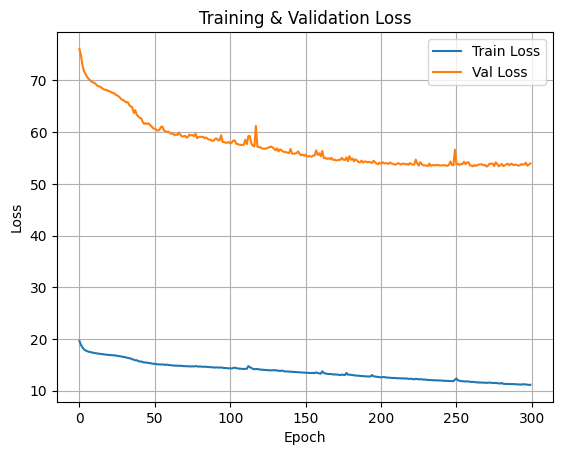

In [ ]:
from piqa import SSIM

class SSIMLoss(SSIM):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def forward(self, x, y):
        return 1. - super().forward(x, y)

generator = UNet(1, 1)
discriminator = PatchDiscriminator(in_channels=2)

criterion_gan = nn.BCELoss()
criterion = SSIMLoss(n_channels=1).cuda()

optimizer_generator = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=1e-9, betas=(0.5, 0.999))

train_loss_history, validation_loss_history = train_gan(
    generator,
    discriminator,
    train_loader,
    validation_loader,
    criterion_gan,
    criterion,
    optimizer_generator,
    optimizer_discriminator,
    epochs=300,
    lambda_loss=100,
    accumulation_steps=4,
)

plot_loss(train_loss_history, validation_loss_history)
plot_test_results(generator, train_loader, device=torch.device("cuda"))
plot_test_results(generator, test_loader, device=torch.device("cuda"))